# Quasi Monte Carlo integration of oscillatory functions on a $d$-simplex

## Analytical reference result

Consider the following integral,

$$
I_N(\{\alpha_1, \alpha_2, \ldots, \alpha_N\}) =
\int_0^1 dt_N \int_0^{t_N} dt_{N-1} \int_0^{t_{N-1}} dt_{N-2} \ldots \int_0^{t_2} dt_1
e^{\alpha_1 t_1 + \alpha_2 t_2 + \ldots + \alpha_N t_N}
$$
with $\Re(\alpha_i) > 0$ and $\Im(\alpha_i) > 0$.

By doing the $t_1$ integral, one can easily prove a recurrence relation
$$
I_N(\{\alpha_1,\alpha_2,\ldots,\alpha_N\}) = \frac{1}{\alpha_1}
\left[
I_{N-1}(\{\alpha_1+\alpha_2,\alpha_3,\ldots,\alpha_N\}) -
I_{N-1}(\{\alpha_2,\alpha_3,\ldots,\alpha_N\})
\right]
$$

with the initial value
$$
I_1(\{\alpha_1\}) = \int_0^1 dt_1 e^{\alpha_1 t_1} = \frac{e^{\alpha_1} - 1}{\alpha_1}.
$$

We can use this result as a reference for quasi Monte Carlo integration of oscillatory functions $\exp(\alpha_1 t_1 + \ldots + \alpha_N t_N)$ over a simplex.

In [1]:
function Iref(α::Vector)
    if length(α) > 1
        return (Iref(pushfirst!(α[3:end], α[1] + α[2])) - Iref(α[2:end])) / α[1]
    else
        return (exp(α[1]) - 1) / α[1]
    end
end

Iref (generic function with 1 method)

In [2]:
println(Iref([1.0im]))
println(Iref([1.0im, 2.0im]))
println(Iref([1.0im, 2.0im, 3.0im]))
println(Iref([1.0im, 2.0im, 3.0im, 4.0im]))

0.8414709848078965 + 0.45969769413186023im
-0.04474258607342274 + 0.40760871072621846im
-0.0882093446808106 - 0.04113411909910483im
0.013658014428020629 - 0.00028502527686075085im


## Reference results for general (complex) frequencies

In [3]:
using SymPy

function Iref_sympy(α::Vector)
    N = length(α)
    t = [symbols("t$(n)", real = true) for n=1:N]
    integrand = exp(sum(α .* t))
    for i=1:N-1
        # SymPy seems to be unhappy about complex integrals of this form (bug?)
        # I have to split it into the real and imaginary parts
        integrand = integrate(real(integrand), (t[i], 0, t[i+1])) +
              1im * integrate(imag(integrand), (t[i], 0, t[i+1]))
    end
    integrate(integrand, (t[N], 0, 1)).evalf()
end

println(Iref_sympy([1.0im]))
println(Iref_sympy([1.0im, 2.0im]))
println(Iref_sympy([1.0im, 2.0im, 3.0im]))
println(Iref_sympy([1.0im, 2.0im, 3.0im, 4.0im]))

println(Iref_sympy([1.0im, -1.0im, 2.0im, -2.0im, -1.5im, 1.5im]))

0.841470984807897 + 0.45969769413186*I
-0.0447425860734228 + 0.407608710726218*I
-0.0882093446808106 - 0.0411341190991048*I
0.0136580144280206 - 0.000285025276860748*I
0.00127621430262309 - 0.000276752621433562*I


## Transformations of the unit hypercube

<https://doi.org/10.1016/j.cam.2004.03.019>

In [4]:
# Sort
TransformSort(x::Vector{Float64}) = sort(x)

# Root
function TransformRoot(x::Vector{Float64})
    s = length(x)
    y = Vector{Float64}(undef, s)
    y[end] = x[end] ^ (1.0 / s)
    for i = s-1:-1:1
        y[i] = y[i+1] * (x[i] ^ (1.0 / i))
    end
    y
end

TransformRoot (generic function with 1 method)

## Quasi Monte Carlo integration

In [5]:
import PyCall; PyCall.pygui(:tk);
import PyPlot; const plt = PyPlot; plt.pygui(false); plt.svg(true);

In [6]:
import LinearAlgebra: dot
import Sobol: SobolSeq, next!

make_f(α::Vector) = x -> exp(dot(α, x))

seq_dim(::SobolSeq{N}) where {N} = N

qMCIntegrate(f, seq, trans, N::Int) = sum(f(trans(next!(seq))) for n=1:N) / (N * factorial(seq_dim(seq)))

qMCIntegrate (generic function with 1 method)

## Visualization

In [7]:
function plot_diff(N_range, vals, ref)
    plt.plot(N_range, abs.(vals .- ref))
    plt.xlabel("\$N\$")
    plt.ylabel("Absolute difference")
    plt.xscale("log")
    plt.yscale("log")
end

plot_diff (generic function with 1 method)

$d=2$

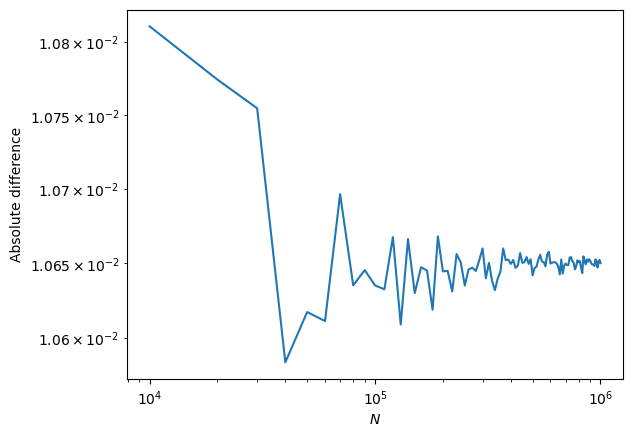

vals[end] = -0.004399444990970043 - 0.00532474449378605im
ref = -0.004405175238244365 + 0.005325288085325537im


-0.004405175238244365 + 0.005325288085325537im

In [8]:
α = [2π*2.2im + 0.1, 2π*2.4im + 0.2]
f = make_f(α)

ref = Iref(α)
vals = []
N_range = 10000:10000:1000000

for N = N_range
    append!(vals, qMCIntegrate(f, SobolSeq(length(α)), TransformRoot, N))
end

plot_diff(N_range, vals, ref)

@show vals[end]
@show ref

$d = 8$

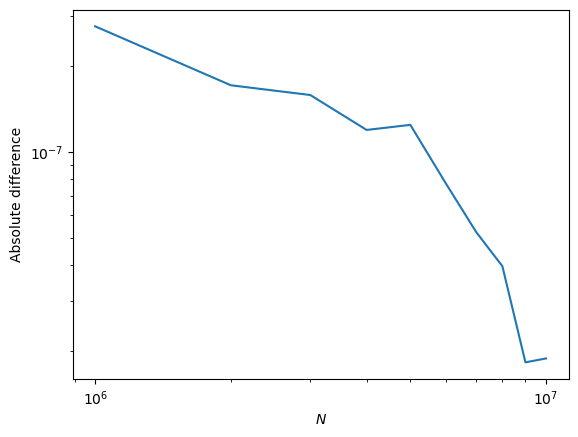

vals[end] = -1.2679486748887673e-8 + 1.1186941949222187e-8im
ref = 2.1204769270401938e-9 - 5.800498783387406e-10im


2.1204769270401938e-9 - 5.800498783387406e-10im

In [9]:
α = [2π*1.2im + 1,
     2π*1.4im - 1,
     2π*1.6im + 1,
     2π*1.8im - 1,
     2π*1.0im + 1,
     2π*1.2im - 1,
     2π*1.4im + 1]
f = make_f(α)

ref = Iref(α)
vals = []
N_range = 1000000:1000000:10000000

for N = N_range
    append!(vals, qMCIntegrate(f, SobolSeq(length(α)), TransformRoot, N))
end

plot_diff(N_range, vals, ref)

@show vals[end]
@show ref

# Effect of warping

In [32]:
# Make the model function p_n(u) out of h_i()
function make_model_function(h::Vector)
    u -> begin
        # Transformation u -> v
        v = prepend!([u[i] - u[i-1] for i=2:length(u)], u[1])
        # Product of h(v_i)
        reduce(*, [hi(vi) for (hi, vi) in zip(h, v)])
    end
end

# Quasi Monte Carlo integration with warping
function qMCIntegrateWithWarping(f, p, seq, trans, N::Int)
    r = 0
    for i = 1:N
        x = next!(seq)
        u = trans(x)
        if u[end] > 1.0
            continue # Skip u-points outside the physical domain
        end
        r += f(u) / p(u)
    end
    r / N
end

qMCIntegrateWithWarping (generic function with 1 method)

## Exponential model function

In [11]:
# Make p_d(u) from the exponential h(v)
function make_exp_model_function(τ::Real, d::Int)
    make_model_function(repeat([v -> exp(-v/τ)], d))
end

# Make the corresponding transformation x -> u
function make_exp_trans(τ::Real)
    x -> begin
        u = Vector{Real}(undef, length(x))
        u[1] = -τ * log(1 - x[1])
        for i = 2:length(x)
            u[i] = u[i-1] -τ * log(1 - x[i])
        end
        u
    end
end

make_exp_trans (generic function with 1 method)

$d=2$

In [33]:
α = [-(2π*0.1im - 0.1),(2π*0.1im - 0.1)]
f = make_f(α)

@show ref = Iref_sympy(α)
vals = []
N_range = 100:100:100

τ = 1
p = make_exp_model_function(τ, 2)
trans = make_exp_trans(τ)

for N = N_range
    append!(vals, qMCIntegrateWithWarping(f, p, SobolSeq(length(α)), trans, N))
end
@show vals[end]

#plot_diff(N_range, vals, ref)

ref = Iref_sympy(α) = 0.468447455697192 + 0.0977212671378644*I
vals[end] = 0.45677781885829305 - 0.0913575433049057im


0.45677781885829305 - 0.0913575433049057im